# Supervised Classsification

There are many different types of models we can use for classification,
each of these models have types of problems they are well suited to.
The goal of this notebook is to identify algorithms 
that will effectively classify our dataset
which we can then investigate further.

In [1]:
%load_ext autoreload
%autoreload 1

%matplotlib inline

import numpy as np
from sklearn import cluster, decomposition, preprocessing
from sdanalysis.order import compute_neighbours, relative_orientations, relative_distances
from sdanalysis.figures import plot_frame
import matplotlib.pyplot as plt
import joblib

import warnings
warnings.filterwarnings('ignore')

# Import project tools
import sys
sys.path.append('../src')
%aimport trimer
from trimer import plot_clustering, read_all_files, classify_mols, plot_confusion_matrix

# Configure Bokeh to output the figures to the notebook
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

The choice of the 100th frame of the trajectory is
to choose a configuration in which
there is sufficient thermal motion in the crystal region.
This motion is to be indicative of the range of values for the crystal.

At high temperatures, 
the 1st (0 indexed) frame of the dump dataset includes
significant melting of the crysal
which is not at all useful for
the training of this algorithm.

In [2]:
var_snaps = read_all_files(
    "../data/simulation/dataset/output/", 
    index=100,
    pattern="trajectory-*.gsd"
)

variables = [v for v, _ in var_snaps]
snaps = [s for _, s in var_snaps]

### Loading the training data

We need to load in the training dataset we created in the first notebook.
At this point we are interested in two sets of data,

- $X$, the input data which is the orientation of the six nearest neighbours
- $y$, the true labelled classification of the data.

In [3]:
classes = np.concatenate(
    [classify_mols(snap, v.crystal) for snap, v in zip(snaps, variables)]
)

In [4]:
orientations = np.concatenate(
    [relative_orientations(s.box, s.position, s.orientation) for s in snaps]
)

In [5]:
mask = classes < 4
X = orientations[mask]
y = classes[mask]

### Collating the models

The first step here is creating a list of models we would like to test.
An excellent property of scikit-learn is 
that all the algorithms have the same API,
allowing us to treat them all in the same way. 

This is not an exhastive list of all the possible classifiers in scikit-learn,
just a smattering for comparison.
For a more exhastive list check out [the scikit-learn documentation](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning),
and feel free to add more to the list.

In [6]:
from sklearn import linear_model, discriminant_analysis, tree, neighbors, naive_bayes, svm, neural_network

ml_models = {
    'LR': linear_model.LogisticRegression(),
    'SGD': linear_model.SGDClassifier(tol=1e-3, max_iter=1000),
    'LDA': discriminant_analysis.LinearDiscriminantAnalysis(),
    'DT': tree.DecisionTreeClassifier(),
    'KNN': neighbors.KNeighborsClassifier(),
    'NB': naive_bayes.GaussianNB(),
#     'SVM': svm.SVC(),
    'NN': neural_network.MLPClassifier()
}

### Testing the Models

With a collection of models to test,
we now need some method of testing the models to compare them.
To perform the initial screening of datasets
we are going to break our training data into two groups,

- the training set, comprising 80% of the molecules
- the validation set, comprising the remaining 20%.

This division of the dataset gives us a set of data 
previously unseen by the algorithms,
giving us a method of testing whether
the algorithm is acutally learning the underlying features,
or just 'memorising' the training data.
This division of data will be through a random selection
so as not to bias the selection of data.

In [7]:
from sklearn import model_selection

validation_size = 0.20
seed = 7

selected = model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed)
X_train, X_validation, y_train, y_validation = selected

To get an idea of the models which
warrant a further investigation,
we can iterate through each of our models.
Each model is scored by breaking the training data into `n_splits`,
using one of these splits for testing and
the remaining splits for training.
This process is referred to as *cross validation*
and typically the number of splits is 10.
For the purposes of this running in a reasonable amount of time,
`n_splits` is set to 2.

In [8]:
scoring='balanced_accuracy'
n_splits = 2
# Typically n_splits would be 10 but it runs much slower
# n_splits = 10

# Iterate through each model in our dictionary of models
for name, model in ml_models.items():
    kfold = model_selection.KFold(n_splits=n_splits, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    print(f'{name:5s}: {cv_results.mean():.5f} ± {cv_results.std():.5f}')

LR   : 0.79285 ± 0.00129
SGD  : 0.78760 ± 0.00675
LDA  : 0.78971 ± 0.00157
DT   : 0.95539 ± 0.00013
KNN  : 0.96332 ± 0.00075
NB   : 0.80948 ± 0.00423
NN   : 0.96188 ± 0.00110


Out of all the algorithms tested, 
there are three that stand out 

- K-Nearest Neighbours (KNN),
- Decision Tree (DT),
- Neural Network (NN)

with accuracies in excess of 95%. 

So with these three algorithms it is likely worth
tweaking the algorithms slightly from 
the defualt paramters in an effort to improve performance.
It is also worth understanding which classes
each of these algorithms is strongest at classifying.
For this additional data we are going to be using a [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).
In a confusion matrix, 
the diagonal elements represent the correct classifications,
while the off diagonal elements are the values 
which were incorrectly classified.

Normalized confusion matrix


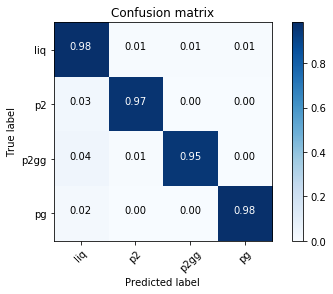

In [9]:
y_pred = ml_models["KNN"].fit(X_train, y_train).predict(X_validation)
plot_confusion_matrix(y_validation, y_pred, classes=['liq', 'p2', 'p2gg', 'pg'])
plt.savefig("../figures/knn-confusion_matrix.pdf")

Normalized confusion matrix


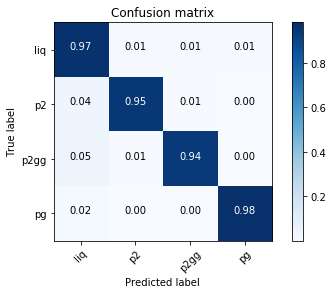

In [10]:
y_pred = ml_models["DT"].fit(X_train, y_train).predict(X_validation)
plot_confusion_matrix(y_validation, y_pred, classes=['liq', 'p2', 'p2gg', 'pg'])

Normalized confusion matrix


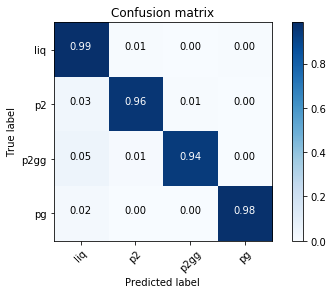

In [11]:
y_pred = ml_models["NN"].fit(X_train, y_train).predict(X_validation)
plot_confusion_matrix(y_validation, y_pred, classes=['liq', 'p2', 'p2gg', 'pg'])

It is interesting to note that all of the models
have the most difficulty with the liquid/crystal characterisation,
with the largest proportion of false positives being 
crystal incorrectly classified as liquid. 
To make this model we have created persistent
it needs to be saved which is done using `joblib`.

In [12]:
knn = ml_models['KNN']
knn.fit(X_train, y_train)
joblib.dump(knn, '../models/knn-trimer.pkl') 

['../models/knn-trimer.pkl']

In [13]:
dt = ml_models['DT']
dt.fit(X_train, y_train)
joblib.dump(dt, '../models/dt-trimer.pkl') 

['../models/dt-trimer.pkl']

In [14]:
nn = ml_models['NN']
nn.fit(X_train, y_train)
joblib.dump(nn, '../models/nn-trimer.pkl') 

['../models/nn-trimer.pkl']